#NEURAL NETWORKS AND DEEP LEARNING
# Homework 3
---
Elena Leonelli - mat.2028635 - M.Sc. Physics of data

In [1]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

In [9]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim,128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

## Exploration Policy

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [10]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.


In [11]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

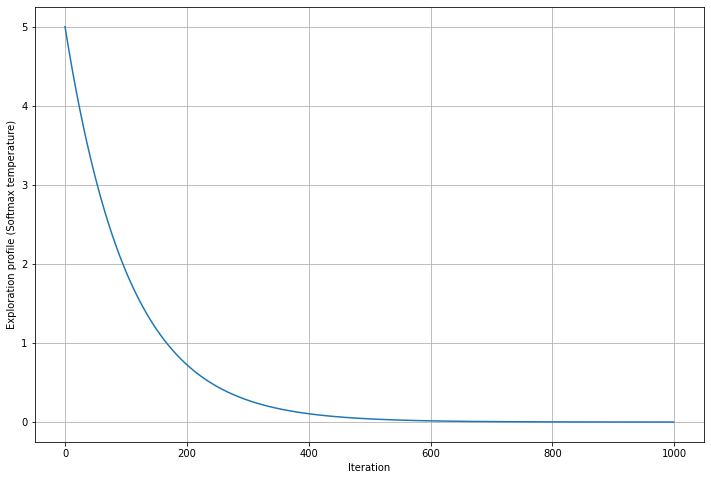

In [12]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
plt.show()

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

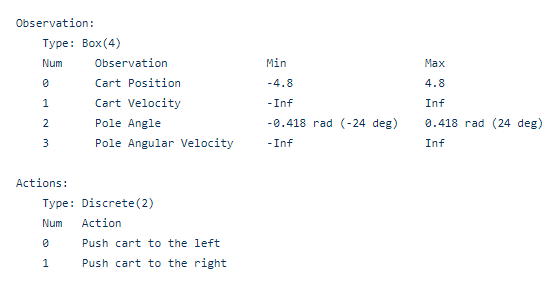

In [13]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [14]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 15.0
EPISODE 2 - FINAL SCORE: 11.0
EPISODE 3 - FINAL SCORE: 9.0
EPISODE 4 - FINAL SCORE: 14.0
EPISODE 5 - FINAL SCORE: 15.0
EPISODE 6 - FINAL SCORE: 18.0
EPISODE 7 - FINAL SCORE: 34.0
EPISODE 8 - FINAL SCORE: 15.0
EPISODE 9 - FINAL SCORE: 23.0
EPISODE 10 - FINAL SCORE: 15.0


In [ ]:
# Display the videos, not required outside Colab
#show_videos()

# Network update

## Update function

In [15]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

# Training loop

This is a training loop using softmax policy and Huber loss.

In [16]:
def initialization(params):

  ### Initialize the replay memory
  replay_mem = ReplayMemory(params['replay_memory_capacity'])    

  ### Initialize the policy network
  policy_net = DQN(params['state_space_dim'], params['action_space_dim'])

  ### Initialize the target network with the same weights of the policy network
  target_net = DQN(params['state_space_dim'], params['action_space_dim'])
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
  optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

  ### Initialize the loss function (Huber loss)
  loss_fn = nn.SmoothL1Loss()

  return policy_net, target_net, replay_mem, optimizer, loss_fn




In [17]:
def training(exploration_profile,parameters):

  policy_net, target_net, replay_mem, optimizer, loss_fn = initialization(parameters) #initiate all the parameters

  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(0) # Set a random seed for the environment (reproducible results)

  # This is for creating the output video in Colab, not required outside Colab
  #env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
  final_score = []

  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off
      while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += parameters['bad_state_penalty']
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > parameters['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, parameters['gamma'], optimizer, loss_fn, parameters['batch_size'])

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % parameters['target_net_update_steps'] == 0:
          #print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      #print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
      final_score.append(score)

  env.close()

  return final_score, policy_net

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

In [18]:

parameters = {'replay_memory_capacity':10000,
              'state_space_dim':4,
              'action_space_dim':2,
              'lr':1e-2,
              'gamma':0.97,
              'target_net_update_steps':10,
              'batch_size':128,
              'bad_state_penalty':0,
              'min_samples_for_training':1000
              }

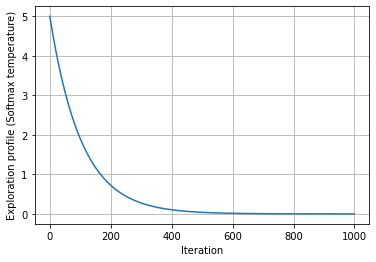

In [23]:
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(6,4))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
plt.show()

In [24]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


final_score_res, policy_net_res = training(exploration_profile,parameters)

  0%|          | 0/1000 [00:00<?, ?it/s]

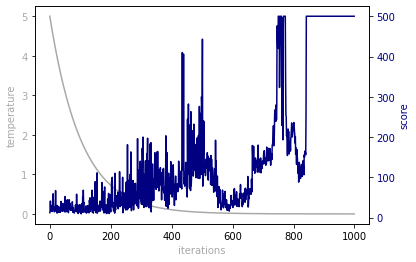

In [25]:
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('iterations',color='darkgrey') 
ax1.set_ylabel('temperature',color='darkgrey') 
ax1.plot(exploration_profile, color='darkgrey') 
ax1.tick_params(axis ='y', labelcolor='darkgrey') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('score',color='navy') 
ax2.plot(final_score_res,color='navy') 
ax2.tick_params(axis ='y',labelcolor='navy') 


plt.show()

From the plot, it is possible to see that the maximum score is reached when the temperature goes to zero. In the following I will plot some results varying the exploration profile and with different learning rates and gamma, to obtain the best values (i.e. the ones for which the maximum score is reached earlier).

In [26]:
def exp_prof(i,num_iterations = 700):
  exp_decay = np.exp(-np.log(i) / num_iterations * 6)
  return [i * (exp_decay ** k) for k in range(num_iterations)]

In [28]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

initial_value = [2,6]
gamma = [0.97, 0.95]

results_gamma = []

for i in initial_value:
  exploration_profile = exp_prof(i)

  for g in gamma:
    parameters['gamma'] = g

    final_score_res,_ = training(exploration_profile,parameters)
    results_gamma.append(final_score_res)


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

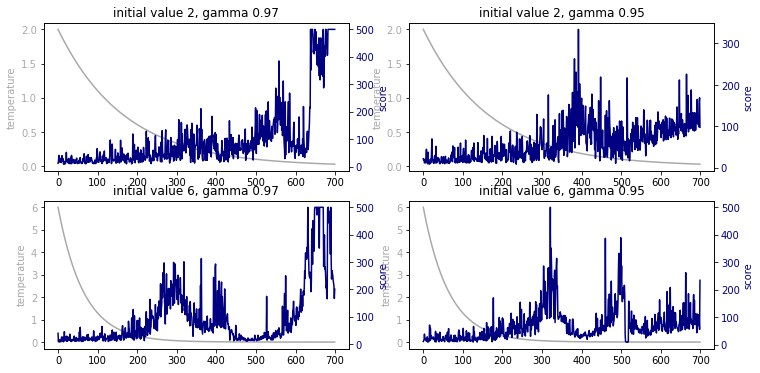

In [29]:
fig,([ax1,ax2],[ax3,ax4])= plt.subplots(2,2,figsize=(12,6))
colors = ['darkgrey','navy']

ax1.plot(exp_prof(initial_value[0]), color=colors[0])
ax1.set_ylabel('temperature', color=colors[0])
ax1.tick_params(axis ='y',labelcolor=colors[0]) 
ax1.set_title('initial value {}, gamma {}'.format(initial_value[0],gamma[0]))

ax2.plot(exp_prof(initial_value[0]), color=colors[0])
ax2.set_ylabel('temperature', color=colors[0])
ax2.tick_params(axis ='y',labelcolor=colors[0]) 
ax2.set_title('initial value {}, gamma {}'.format(initial_value[0],gamma[1]))

ax3.plot(exp_prof(initial_value[1]), color=colors[0])
ax3.set_ylabel('temperature', color=colors[0])
ax3.tick_params(axis ='y',labelcolor=colors[0]) 
ax3.set_title('initial value {}, gamma {}'.format(initial_value[1],gamma[0]))

ax4.plot(exp_prof(initial_value[1]), color=colors[0])
ax4.set_ylabel('temperature', color=colors[0])
ax4.tick_params(axis ='y',labelcolor=colors[0]) 
ax4.set_title('initial value {}, gamma {}'.format(initial_value[1],gamma[1]))


ax11=ax1.twinx()
ax22=ax2.twinx()
ax33=ax3.twinx()
ax44=ax4.twinx()

ax11.plot(results_gamma[0], color=colors[1])
ax11.set_ylabel('score', color=colors[1])
ax11.tick_params(axis ='y',labelcolor=colors[1])

ax22.plot(results_gamma[1], color=colors[1])
ax22.set_ylabel('score', color=colors[1])
ax22.tick_params(axis ='y',labelcolor=colors[1])

ax33.plot(results_gamma[2], color=colors[1])
ax33.set_ylabel('score', color=colors[1])
ax33.tick_params(axis ='y',labelcolor=colors[1])

ax44.plot(results_gamma[3], color=colors[1])
ax44.set_ylabel('score', color=colors[1])
ax44.tick_params(axis ='y',labelcolor=colors[1])
  
plt.show()

In [32]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

parameters['gamma'] = 0.97 #best found above
initial_value = [2,6]
lr = [1e-1,1e-2]

results_lr = []

for i in initial_value:
  exploration_profile = exp_prof(i)

  for l in lr:
    parameters['lr'] = l

    final_score_res,_ = training(exploration_profile,parameters)
    results_lr.append(final_score_res)


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

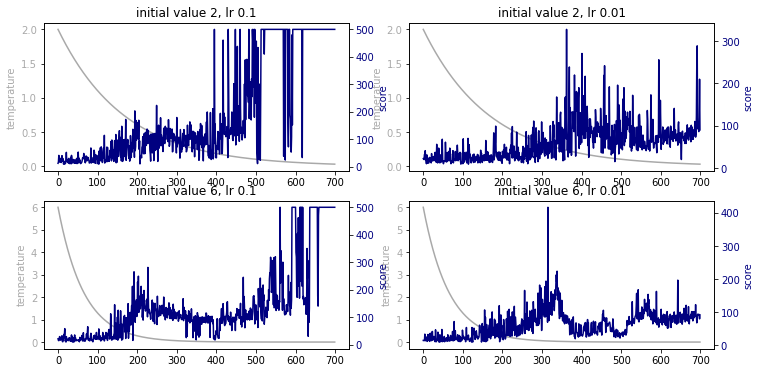

In [33]:
fig,([ax1,ax2],[ax3,ax4])= plt.subplots(2,2,figsize=(12,6))
colors = ['darkgrey','navy']

ax1.plot(exp_prof(initial_value[0]), color=colors[0])
ax1.set_ylabel('temperature', color=colors[0])
ax1.tick_params(axis ='y',labelcolor=colors[0]) 
ax1.set_title('initial value {}, lr {}'.format(initial_value[0],lr[0]))

ax2.plot(exp_prof(initial_value[0]), color=colors[0])
ax2.set_ylabel('temperature', color=colors[0])
ax2.tick_params(axis ='y',labelcolor=colors[0]) 
ax2.set_title('initial value {}, lr {}'.format(initial_value[0],lr[1]))

ax3.plot(exp_prof(initial_value[1]), color=colors[0])
ax3.set_ylabel('temperature', color=colors[0])
ax3.tick_params(axis ='y',labelcolor=colors[0]) 
ax3.set_title('initial value {}, lr {}'.format(initial_value[1],lr[0]))

ax4.plot(exp_prof(initial_value[1]), color=colors[0])
ax4.set_ylabel('temperature', color=colors[0])
ax4.tick_params(axis ='y',labelcolor=colors[0]) 
ax4.set_title('initial value {}, lr {}'.format(initial_value[1],lr[1]))


ax11=ax1.twinx()
ax22=ax2.twinx()
ax33=ax3.twinx()
ax44=ax4.twinx()

ax11.plot(results_lr[0], color=colors[1])
ax11.set_ylabel('score', color=colors[1])
ax11.tick_params(axis ='y',labelcolor=colors[1])

ax22.plot(results_lr[1], color=colors[1])
ax22.set_ylabel('score', color=colors[1])
ax22.tick_params(axis ='y',labelcolor=colors[1])

ax33.plot(results_lr[2], color=colors[1])
ax33.set_ylabel('score', color=colors[1])
ax33.tick_params(axis ='y',labelcolor=colors[1])

ax44.plot(results_lr[3], color=colors[1])
ax44.set_ylabel('score', color=colors[1])
ax44.tick_params(axis ='y',labelcolor=colors[1])
  
plt.show()

# Final test

For the final training is done with learning rate = 0.1, gamma = 0.97, and the exploration profile as an exponential decay starting from 2 (according to the previous plots).

After, I perform the test with 10 episodes.

In [34]:

parameters_best = {'replay_memory_capacity':10000,
              'state_space_dim':4,
              'action_space_dim':2,
              'lr':1e-1,
              'gamma':0.97,
              'target_net_update_steps':10,
              'batch_size':128,
              'bad_state_penalty':0,
              'min_samples_for_training':1000
              }

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

exploration_profile = exp_prof(2)

#training best to have the policy_net
final_score, policy_net = training(exploration_profile,parameters_best)

  0%|          | 0/700 [00:00<?, ?it/s]

In [35]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
#show_videos()

# $\epsilon$-greedy

In this section I use the epsilon greedy policy, with a linear exploration profile.

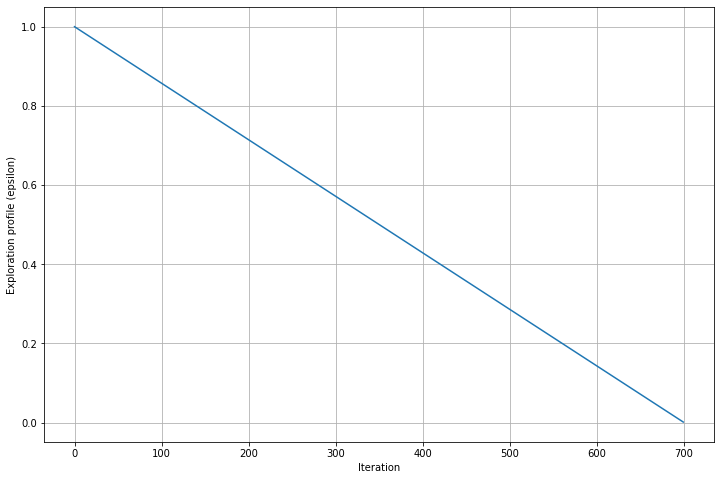

In [36]:
### Define exploration profile
initial_value = 1
num_iterations = 700
exploration_profile = [initial_value * (1-i/num_iterations) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (epsilon)')
plt.show()

In [37]:
def training_eps(exploration_profile,parameters):

  policy_net, target_net, replay_mem, optimizer, loss_fn = initialization(parameters) #initiate all the parameters

  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(0) # Set a random seed for the environment (reproducible results)

  # This is for creating the output video in Colab, not required outside Colab
  #env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
  final_score = []

  for episode_num, eps in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off
      while not done:

        # Choose the action following the policy
        action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=eps)
        
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += parameters['bad_state_penalty']
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > parameters['min_samples_for_training']: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, parameters['gamma'], optimizer, loss_fn, parameters['batch_size'])

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % parameters['target_net_update_steps'] == 0:
          #print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      #print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
      final_score.append(score)

  env.close()

  return final_score, policy_net

In [38]:
parameters = {'replay_memory_capacity':10000,
              'state_space_dim':4,
              'action_space_dim':2,
              'lr':1e-1,
              'gamma':0.97,
              'target_net_update_steps':10,
              'batch_size':128,
              'bad_state_penalty':0,
              'min_samples_for_training':1000
              }

In [39]:
final_score_eps, policy_net_eps = training_eps(exploration_profile,parameters)

  0%|          | 0/700 [00:00<?, ?it/s]

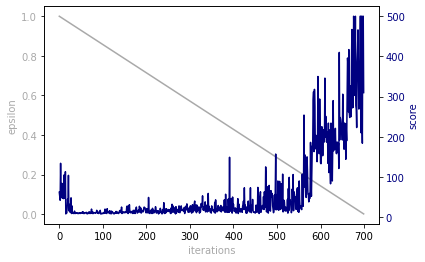

In [40]:
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('iterations',color='darkgrey') 
ax1.set_ylabel('epsilon',color='darkgrey') 
ax1.plot(exploration_profile, color='darkgrey') 
ax1.tick_params(axis ='y', labelcolor='darkgrey') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('score',color='navy') 
ax2.plot(final_score_eps,color='navy') 
ax2.tick_params(axis ='y',labelcolor='navy') 


plt.show()

The results show that the score is higher for lower values of the temperature, and in particular under a threshold of approx. 0.2.

# MOUNTAIN CAR environment

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

[link](https://www.gymlibrary.ml/environments/classic_control/mountain_car/)

The difference with this environment is that the agent is penalised with a reward of -1 for each timestep, since the goal is to reach the flag placed on top of the right hill as quickly as possible. One episode has a duration of 200 timesteps.


In this case, the solution of the game comes only after reaching randomly the flag for the first time, without any reward to guide. Because this is very unlike, I modified the reward function in this way:

if position > -0.45:
  score += height*10\
elif position $\in$ (-0.45, -0.65):
  score += 0 \
else:
  score += heigh



In [ ]:
### Create environment 
env = gym.make("MountainCar-v0") # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make("MountainCar-v0")
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(12): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the episode ends (200 steps or reaches the red flag)
    while not done:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Visually render the environment (optional, comment this line to speed up the simulation)
      #env.render()

      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: -200.0
EPISODE 2 - FINAL SCORE: -200.0
EPISODE 3 - FINAL SCORE: -200.0
EPISODE 4 - FINAL SCORE: -200.0
EPISODE 5 - FINAL SCORE: -200.0
EPISODE 6 - FINAL SCORE: -200.0
EPISODE 7 - FINAL SCORE: -200.0
EPISODE 8 - FINAL SCORE: -200.0
EPISODE 9 - FINAL SCORE: -200.0
EPISODE 10 - FINAL SCORE: -200.0
EPISODE 11 - FINAL SCORE: -200.0
EPISODE 12 - FINAL SCORE: -200.0


Here the reward is not modified, and because the car never reaches the flag, the final score is always -200.

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
min_samples_for_training = 100   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Exploration profile

I used an epsilon-greedy policy, with a customed shape. This is to give enough freedom to explore in the first episodes, and then progressively enhancing the role of learning from previous successes.

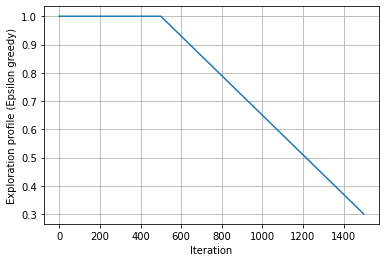

In [ ]:
num_iterations = 1500 
## a gradino iniziale
norm = num_iterations-num_iterations//3

exploration_profile = [1 for i in range(num_iterations//3)]+[(1-0.7*i/norm) for i in range(norm)]

### Plot exploration profile
plt.figure(figsize=(6,4))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Epsilon greedy)')
plt.show()

In [ ]:
# Initialize the Gym environment
env = gym.make("MountainCar-v0")
env.seed(0) # Set a random seed for the environment (reproducible results)

saving_score = []
maxpos = []
minpos = []
initpos = []
# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes
tracking_success = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    max_position = -1.2
    min_position = 0.6
    initpos.append(state[0])

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)#softmax
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score
      
      if next_state[0] > -0.45:
        score += (np.sin(3*next_state[0])*0.45 + 0.55)*10 
      elif next_state[0] < -0.45 and next_state[0] > -0.65:
        score += 0 
      else:
        score += (np.sin(3*next_state[0])*0.45 + 0.55)


      # Keep track of max and min position
      if next_state[0] > max_position:
          max_position = next_state[0]

      if next_state[0] < min_position:
          min_position = next_state[0]


      # Adjust reward for task completion
      if next_state[0] >= 0.5:
          score += 100
          tracking_success.append(episode_num)


      # Update the replay memory
      replay_mem.push(state, action, next_state, score)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state
    

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network


    saving_score.append(score)
    maxpos.append(max_position)
    minpos.append(min_position)

env.close()

  0%|          | 0/1500 [00:00<?, ?it/s]

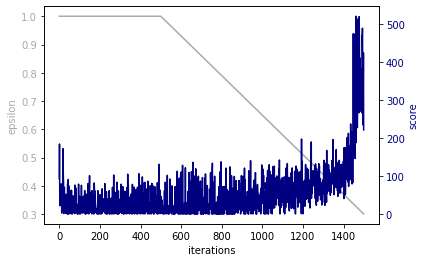

In [ ]:
# Create Plot

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('iterations',color='black') 
ax1.set_ylabel('epsilon',color='darkgrey') 
ax1.plot(exploration_profile, color='darkgrey') 
ax1.tick_params(axis ='y', labelcolor='darkgrey') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('score',color='navy') 
ax2.plot(saving_score,color='navy') 
ax2.tick_params(axis ='y',labelcolor='navy') 


plt.show()

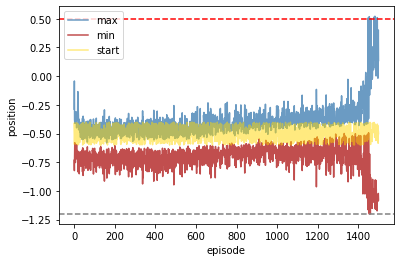

In [ ]:
#MAX and MIN positions while training
plt.plot(maxpos, color='steelblue', label='max', alpha=0.8)
plt.plot(minpos, color='firebrick', label='min', alpha=0.8)
plt.plot(initpos, color='gold', label='start', alpha=0.5)

plt.axhline(y=0.5, color='red', linestyle='--')
plt.axhline(y=-1.2, color='grey', linestyle='--')

plt.ylabel('position')
plt.xlabel('episode')

plt.legend()
plt.show()

I plot also the maximum position reached for each episode, and the minumum, to have an idea of the behaviour ofthe car. In fact, from the graph above is possible to see that the car is able to reach the flag (position = 0.5) when has a lot of oscillations also in the extreme-left part of the valley.

Below, I print the episodes when the car reaches the flag.

In [ ]:
#List of the episodes won

tracking_success

[1448, 1453, 1454, 1461, 1477, 1478, 1481, 1492, 1493]

# Final test

As the final test shows, the training performed is not sufficient to permit to solve the game.

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    goal = 'no'

    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)


      # Visually render the environment
      #env.render()

      # Update the final score 
      if next_state[0] > -0.45:
        score += (np.sin(3*next_state[0])*0.45 + 0.55)*10 
      elif next_state[0] < -0.45 and next_state[0] > -0.65:
        score += 0 
      else:
        score += (np.sin(3*next_state[0])*0.45 + 0.55)

      reward += reward

      # Adjust reward for task completion
      if next_state[0] >= 0.5:
          score += 100
          goal = -reward


      # Set the current state for the next iteration
      state = next_state

    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score} - FLAG REACHED: {goal}") 

env.close()

EPISODE 1 - FINAL SCORE: 306.4187000447566 - FLAG REACHED: no
EPISODE 2 - FINAL SCORE: 277.3000691833995 - FLAG REACHED: no
EPISODE 3 - FINAL SCORE: 251.83628698159782 - FLAG REACHED: no
EPISODE 4 - FINAL SCORE: 273.546729783526 - FLAG REACHED: no
EPISODE 5 - FINAL SCORE: 299.9157368391728 - FLAG REACHED: no
EPISODE 6 - FINAL SCORE: 254.16099374956264 - FLAG REACHED: no
EPISODE 7 - FINAL SCORE: 261.05900820753413 - FLAG REACHED: no
EPISODE 8 - FINAL SCORE: 253.38535921710076 - FLAG REACHED: no
EPISODE 9 - FINAL SCORE: 306.5247653129179 - FLAG REACHED: no
EPISODE 10 - FINAL SCORE: 251.2813338421626 - FLAG REACHED: no
